# Importing data from a sample csv


In [11]:
# not sure why the instructor suggests using this csv method, when pandas can import an xls file directly
import csv

# This is just to show that I am able to read a csv file
with open("sample-data.csv", "r") as file:
    reader = csv.reader(file, delimiter=",")
    for row in reader:
        print(row)

['first_name', 'last_name', 'email', 'phone']
['John', 'Doe', 'john@gmail.com', '1234567890']
['Kelly', 'Smith', 'ks@gmail.com', '3444583989']
['Roger', 'Moore', 'moore@gmail.com', '8876567890']
['Edward', 'Smith', 'esmith@gmail.com', '2222223332']
['Lenny', 'Warren', 'coollenny@yahoo.com', '3333333333']
['Trish', 'Lopez', 'lolo@gmail.com', '3432223833']


# Create DDL to create the database and tables


In [12]:
# connect to mysql
# first install the mysql-connector-python package using the following command
#   pip install mysql-connector-python

import mysql.connector
import yaml

db = yaml.safe_load(open("secrets.yaml"))

# Establish a connection to the MySQL server
cnx = mysql.connector.connect(
    host=db["DB_HOST"],
    user=db["DB_USER"],  # both root and andrewcbuensalida works
    password=db["DB_PASSWORD"],
)


# Create a cursor object
cursor = cnx.cursor()

# Use the created database
cursor.execute("USE mrts")

# Skip this and all the other inserts if the database already exists

# Drop the database if it exists
cursor.execute("DROP DATABASE IF EXISTS mrts")

# Create a database
cursor.execute("CREATE DATABASE mrts")

# Use the created database
cursor.execute("USE mrts")

# Create the NAICS code table
cursor.execute(
    """
    CREATE TABLE naics_code (
        id INT AUTO_INCREMENT PRIMARY KEY,
        naics_code VARCHAR(255)
    )
"""
)

# Create the kind of business table
cursor.execute(
    """
    CREATE TABLE kind_of_business (
        id INT AUTO_INCREMENT PRIMARY KEY,
        kind_of_business VARCHAR(255)
    )
"""
)

# Create the sales table
cursor.execute(
    """
    CREATE TABLE sales (
        id INT AUTO_INCREMENT PRIMARY KEY,
        sales_amount DECIMAL(10, 2),
        month INT,
        year INT,
        kind_of_business_id INT,
        FOREIGN KEY (kind_of_business_id) REFERENCES kind_of_business(id)
    )
"""
)

# Create the NAICS code-kind of business association table
cursor.execute(
    """
    CREATE TABLE naics_kind_of_business_association (
        naics_code_id INT,
        kind_of_business_id INT,
        FOREIGN KEY (naics_code_id) REFERENCES naics_code(id),
        FOREIGN KEY (kind_of_business_id) REFERENCES kind_of_business(id)
    )
"""
)

# Importing data from mrts csv year 2020 then save into mysql


# Insert kind of business into sql table
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index >= 6 and index <= 70:  # not adjusted industry categories
                # Check if the kind of business already exists
                query = (
                    "SELECT COUNT(*) FROM kind_of_business WHERE kind_of_business = %s"
                )
                data = (row[1],)

                # Execute the query
                cursor.execute(query, data)

                # Fetch the result
                result = cursor.fetchone()

                # Extract the count from the result
                count = result[0]

                # If the kind of business doesn't exist, insert it into the table
                if count == 0:
                    # Insert kind of business in table
                    query = (
                        "INSERT INTO kind_of_business (kind_of_business) VALUES (%s)"
                    )
                    data = (row[1],)

                    # Execute the query
                    cursor.execute(query, data)

                    # Commit the transaction
                    cnx.commit()

# Insert NAICS codes into table
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index >= 6 and index <= 70 and row[0]:  # not adjusted industry categories
                codes = row[0].split(",")

                for code in codes:
                    # Check if the code already exists in the table
                    query = "SELECT COUNT(*) FROM naics_code WHERE naics_code = %s"
                    data = (code,)

                    # Execute the query
                    cursor.execute(query, data)

                    # Fetch the result
                    result = cursor.fetchone()

                    # Extract the count from the result
                    count = result[0]

                    # If the code doesn't exist, insert it into the table
                    if count == 0:
                        query = "INSERT INTO naics_code (naics_code) VALUES (%s)"
                        data = (code,)

                        # Execute the query
                        cursor.execute(query, data)

                        # Commit the transaction
                        cnx.commit()

# Insert NAICS code-kind of business associations into table
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index >= 6 and index <= 70 and row[0]:  # not adjusted industry categories
                codes = row[0].split(",")

                for code in codes:
                    # Get the NAICS code ID
                    query = "SELECT id FROM naics_code WHERE naics_code = %s"
                    data = (code,)

                    # Execute the query
                    cursor.execute(query, data)

                    # Fetch the result
                    result = cursor.fetchone()

                    # Extract the ID from the result
                    naics_code_id = result[0]

                    # Get the kind of business ID
                    query = "SELECT id FROM kind_of_business WHERE kind_of_business = %s"
                    data = (row[1],)

                    # Execute the query
                    cursor.execute(query, data)

                    # Fetch the result
                    result = cursor.fetchone()

                    # Extract the ID from the result
                    kind_of_business_id = result[0]

                    # Insert the association into the table
                    query = "INSERT INTO naics_kind_of_business_association (naics_code_id, kind_of_business_id) VALUES (%s, %s)"
                    data = (naics_code_id, kind_of_business_id)

                    # Execute the query
                    cursor.execute(query, data)

                    # Commit the transaction
                    cnx.commit()

# Insert sales data into table. This takes about 1.5 minutes to run.
for i in range(1992, 2021):
    with open(f"mrtssales92-present/{i}.csv", "r") as file:
        reader = csv.reader(file, delimiter=",")
        for index, row in enumerate(reader):
            if index == 0:
                title = row[0]

            if index >= 6 and index <= 70:  # not adjusted industry categories. This might break if they add or remove kind of businesses.
                #  Get the kind of business id from sql
                query = "SELECT id FROM kind_of_business WHERE kind_of_business = %s"
                data = (row[1],)

                # Execute the query
                cursor.execute(query, data)

                # Fetch the result
                result = cursor.fetchone()

                # Extract the id from the result
                if result:
                    kind_of_business_id = result[0]
                else:
                    print(
                        "No matching id found"
                    )  # maybe could add a new kind of business here

                # sales from january to december
                # sales = row[2:-1] # This is brittle because in 2016 there is an extra empty column after total sales
                sales = row[2:14]

                for index, sales_amount in enumerate(sales):
                    month = index + 1
                    year = int(title.split(":")[-1])
                    if (
                        sales_amount != "(S)" and sales_amount != "(NA)" and sales_amount
                    ):  # There are some data that have a string (S) instead of a proper sales amount, and some are empty. Just don't insert these sales. Might have to make this more generalized.

                        sales_amount_float = float(sales_amount.replace(",", ""))

                        data = [kind_of_business_id, sales_amount_float, month, year]
                        print(data)

                        # The SQL query to insert the data
                        query = "INSERT INTO sales (kind_of_business_id, sales_amount, month, year) VALUES (%s, %s, %s, %s)"

                        # Execute the query
                        cursor.execute(query, data)

                        # Commit the transaction
                        cnx.commit()

# Explore trends


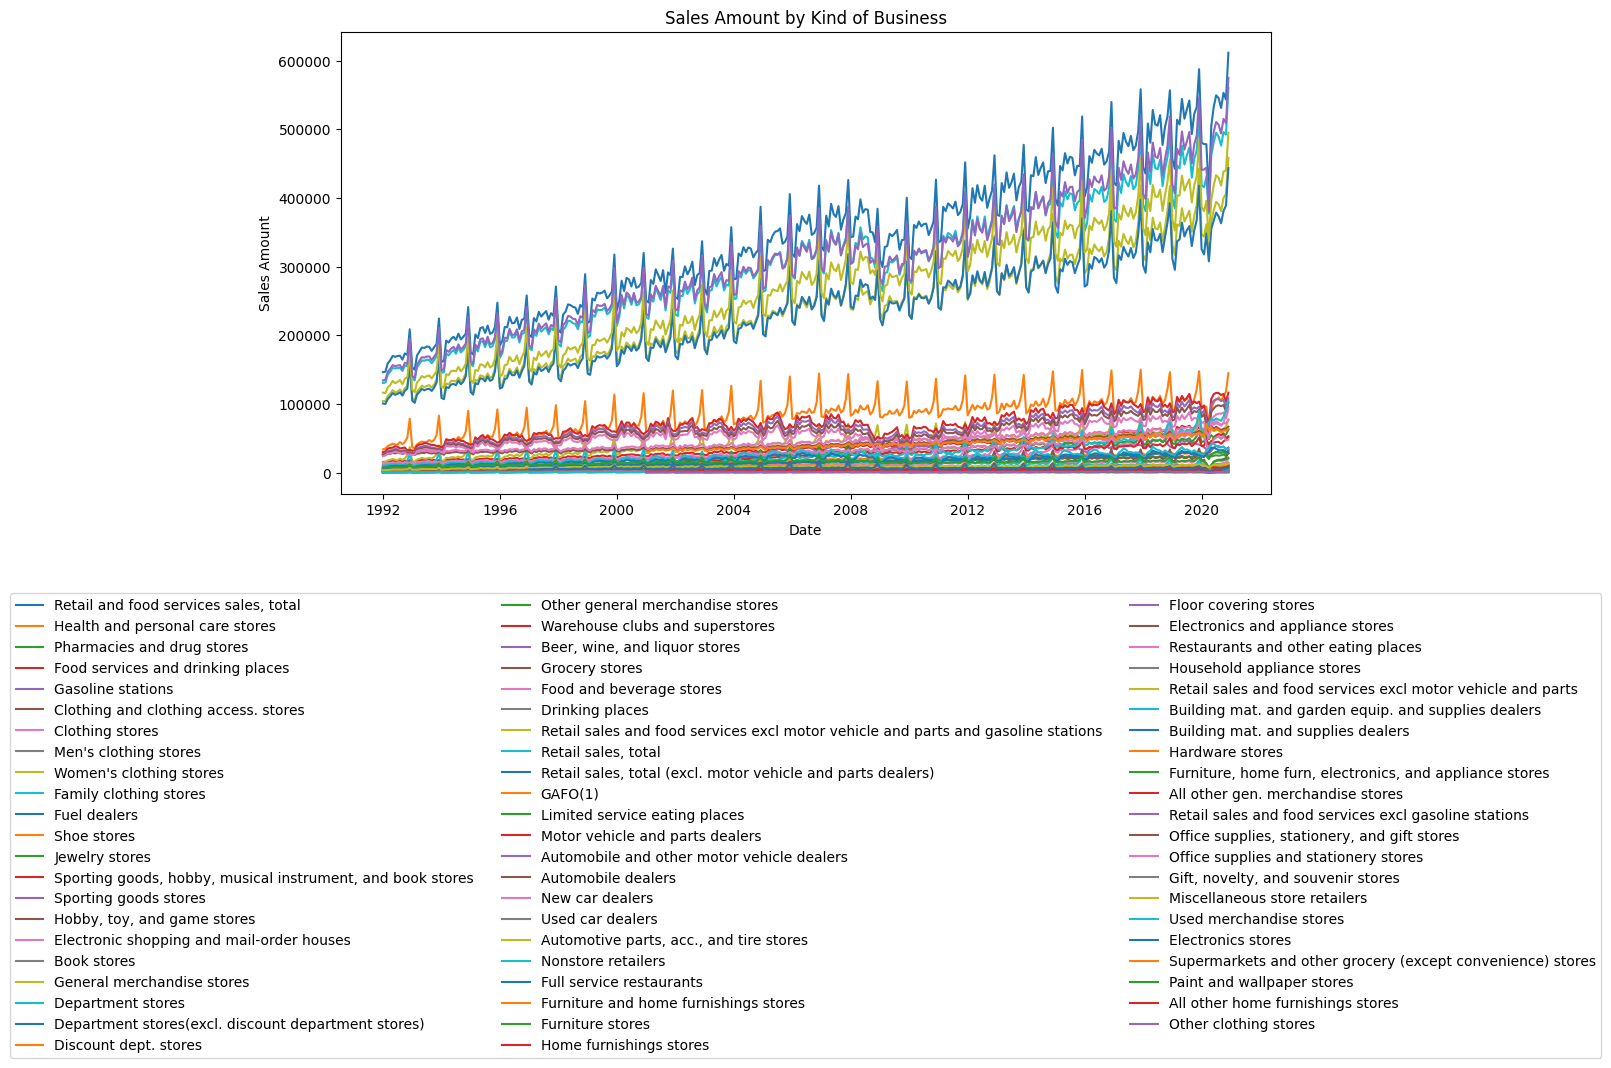

In [3]:
# plot sales trend of all kinds of businesses from 1992 to 2020
import matplotlib.pyplot as plt
import pandas as pd

# Execute the SQL query to select all rows from the "sales" table
query = """SELECT sales_amount, month, year, kind_of_business FROM sales
JOIN kind_of_business
ON sales.kind_of_business_id = kind_of_business.id;"""
cursor.execute(query)

# Fetch all the rows from the result
rows = cursor.fetchall()

# Create a pandas DataFrame from the fetched rows
df = pd.DataFrame(
    rows, columns=["sales_amount", "month", "year", "kind_of_business"]
)

# Convert "month" and "year" columns to datetime format
df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str), format="%Y-%m")

# Set the "date" column as the index
df.set_index("date", inplace=True)
df.sort_index(inplace=True)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the line chart
for kind_of_business in df["kind_of_business"].unique():
    data = df[df["kind_of_business"] == kind_of_business]
    plt.plot(data.index, data["sales_amount"], label=kind_of_business)

# Set the x-axis label
plt.xlabel("Date")

# Set the y-axis label
plt.ylabel("Sales Amount")

# Set the title of the chart
plt.title("Sales Amount by Kind of Business (in millions)")

# Move the legend to the bottom
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3)

# Show the chart
plt.show()

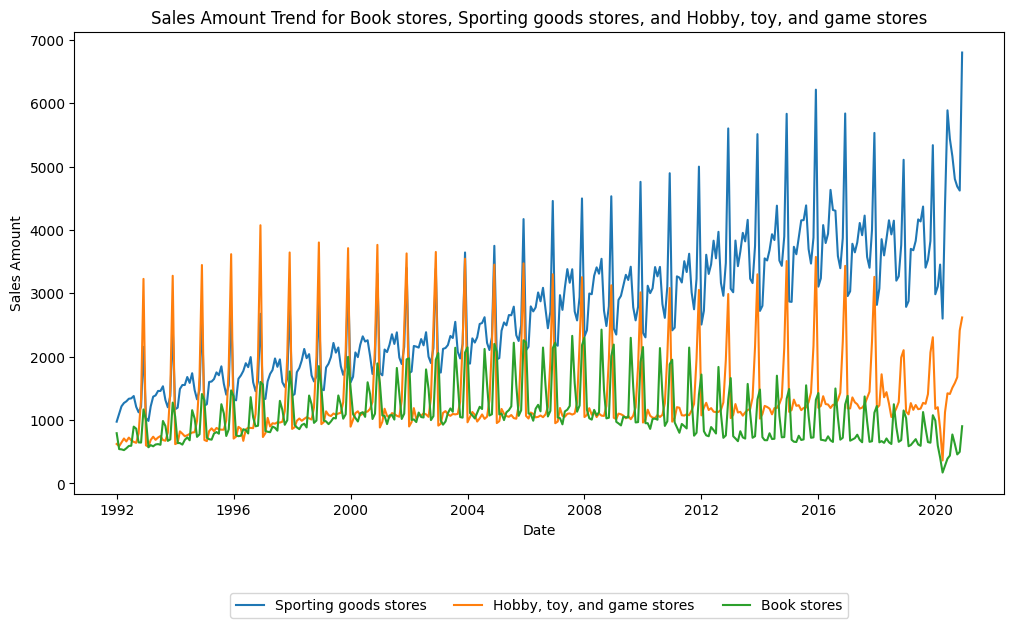

In [4]:
import numpy as np
# Filter the DataFrame for the desired kind_of_business values
kind_to_include = [
    "Sporting goods stores",
    "Hobby, toy, and game stores",
    "Book stores",
]
kind_filter = df["kind_of_business"].isin(kind_to_include)
df_filtered = df[kind_filter]

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the line chart.
for kind_of_business in kind_to_include:
    data = df_filtered[df_filtered['kind_of_business'] == kind_of_business]
    plt.plot(data.index, data['sales_amount'], label=kind_of_business)

# Set the x-axis label
plt.xlabel('Date')

# Set the y-axis label
plt.ylabel('Sales Amount')

# Set the title of the chart
plt.title(
    "Sales Amount Trend for Book stores, Sporting goods stores, and Hobby, toy, and game stores"
)

# Move the legend to the bottom
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)

# Show the chart
plt.show()

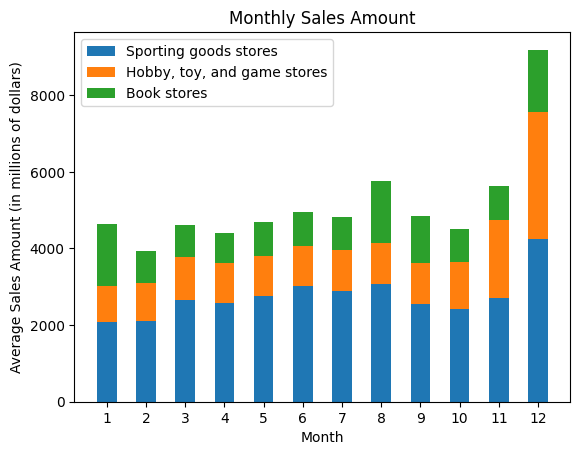

In [5]:
# Trend by month
# Group sales_amount by kind

# build the kind_to_mean_sales dictionary so we can plot the stacked bar chart.
# In the end, it should look like this:
# {
#     "Sporting goods stores": [mean_sales_amount_january, mean_sales_amount_february, ...],
#     "Hobby, toy, and game stores": [mean_sales_amount_january, mean_sales_amount_february, ...],
#     "Book stores": [mean_sales_amount_january, mean_sales_amount_february, ...]
# }
kind_to_mean_sales = {}
for kind_of_business in kind_to_include:
    data = df_filtered[df_filtered["kind_of_business"] == kind_of_business]
    monthly_sales_avg = data.groupby("month")["sales_amount"].mean()
    kind_to_mean_sales[kind_of_business] = monthly_sales_avg.values.astype(float)

months = df_filtered["month"].unique()
width = 0.5
bottom = np.zeros(12)

for kind, mean_sales in kind_to_mean_sales.items():
    p = plt.bar(months, mean_sales, width, label=kind, bottom=bottom)
    bottom += mean_sales # bottom is the bottom of each kind of business shifted upwards by the mean_sales of the other kinds of businesses


# Set the labels and title
plt.xlabel('Month')
plt.ylabel('Average Sales Amount (in millions of dollars)')
plt.title('Monthly Sales Amount')
plt.xticks(months)

# Add a legend
plt.legend()

# Show the plot
plt.show()

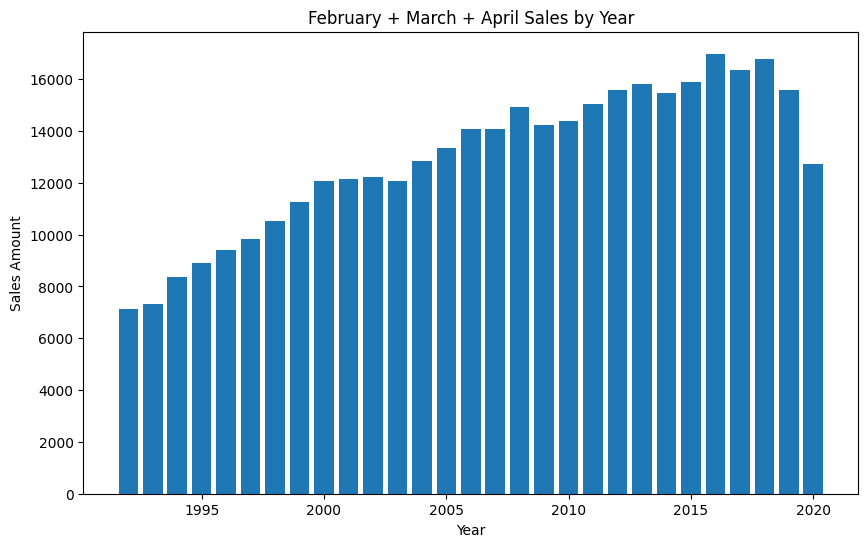

In [6]:
# Are there any changes in 2020?

# Filter the data for the first quarter sales
first_quarter_sales = df_filtered[df_filtered["month"].isin([2, 3, 4])]

# Group the sales by year and calculate the total sales for each year
quarterly_sales_by_year = first_quarter_sales.groupby('year')['sales_amount'].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(quarterly_sales_by_year.index, quarterly_sales_by_year.values)
plt.xlabel('Year')
plt.ylabel('Sales Amount')
plt.title('February + March + April Sales by Year')
plt.show()

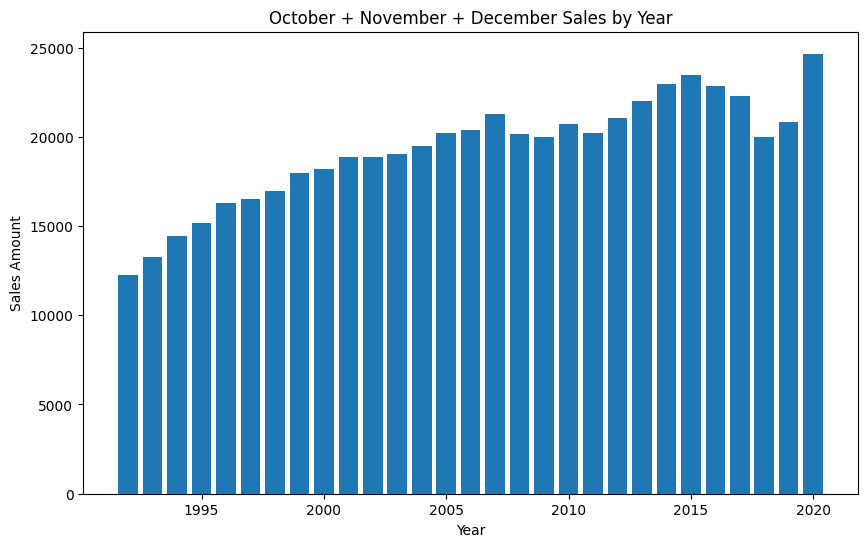

In [7]:
# Filter the data for the first quarter sales
last_quarter_sales = df_filtered[df_filtered["month"].isin([10,11,12])]

# Group the sales by year and calculate the total sales for each year
quarterly_sales_by_year = last_quarter_sales.groupby("year")["sales_amount"].sum()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(quarterly_sales_by_year.index, quarterly_sales_by_year.values)
plt.xlabel("Year")
plt.ylabel("Sales Amount")
plt.title("October + November + December Sales by Year")
plt.show()

In [8]:
df[df["kind_of_business"].isin(["Men's clothing stores", "Women's clothing stores"])]

,sales_amount,month,year,kind_of_business
date,,,,
1992-01-01,701.00,1,1992,Men's clothing stores
1992-01-01,1873.00,1,1992,Women's clothing stores
1992-02-01,1991.00,2,1992,Women's clothing stores
1992-02-01,658.00,2,1992,Men's clothing stores
1992-03-01,2403.00,3,1992,Women's clothing stores
...,...,...,...,...
2020-09-01,401.00,9,2020,Men's clothing stores
2020-10-01,2634.00,10,2020,Women's clothing stores
2020-11-01,2726.00,11,2020,Women's clothing stores


# Explore percentage change


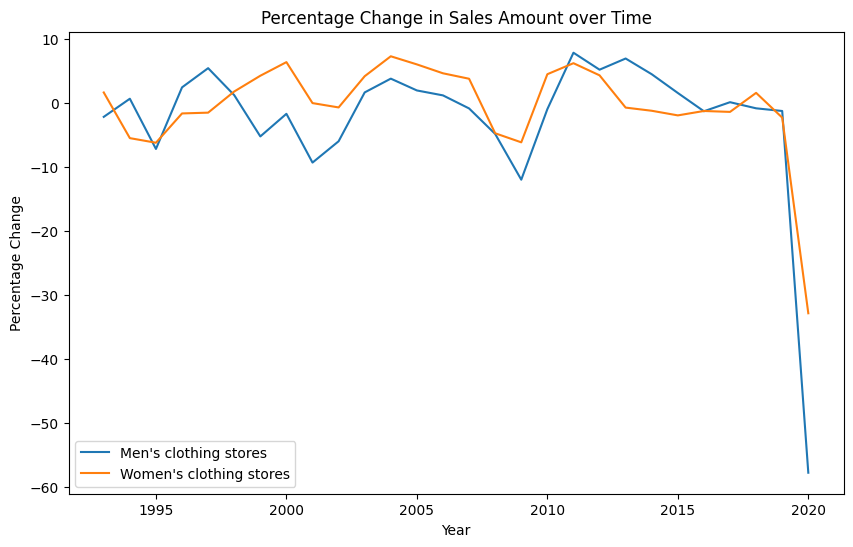

In [9]:
# Filter the DataFrame for the two kinds of businesses
df_filtered = df[
    df["kind_of_business"].isin(["Men's clothing stores", "Women's clothing stores"])
]

# Group by year and kind_of_business, and calculate the sum of sales_amount
df_grouped = (
    df_filtered.groupby([df_filtered.index.year, "kind_of_business"])["sales_amount"]
    .sum()
    .unstack() # takes the right most vertical index and makes it a column index
)
# Calculate the percentage change
df_pct_change = df_grouped.pct_change() * 100

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(
    df_pct_change.index,
    df_pct_change["Men's clothing stores"],
    label="Men's clothing stores",
)
plt.plot(
    df_pct_change.index,
    df_pct_change["Women's clothing stores"],
    label="Women's clothing stores",
)

# Adding labels and title
plt.xlabel("Year")
plt.ylabel("Percentage Change")
plt.title("Percentage Change in Sales Amount over Time")

# Adding legend
plt.legend()

# Displaying the chart
plt.show()

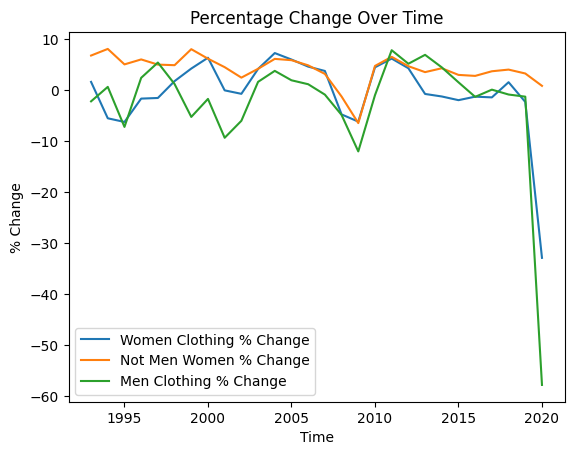

In [10]:
# For Men's and Women's clothing stores and all other categories, what is the percentage change over time?

# Filter the data for Men's clothing stores
men_clothing_df = df[df['kind_of_business'] == "Men's clothing stores"]

# Group the data by year and calculate the percent change in sales_amount
men_clothing_pct_change = (
    men_clothing_df.groupby([men_clothing_df.index.year])["sales_amount"]
    .sum()
    .pct_change() * 100
)

# Filter the data for Women's clothing stores
women_clothing_df = df[df["kind_of_business"] == "Women's clothing stores"]

# Group the data by year and calculate the percent change in sales_amount
women_clothing_pct_change = (
    women_clothing_df.groupby([women_clothing_df.index.year])["sales_amount"]
    .sum()
    .pct_change()
    * 100
)

not_men_women_df = df[~df["kind_of_business"].isin(["Men's clothing stores", "Women's clothing stores"])]

not_men_women_pct_change = (
    not_men_women_df.groupby([not_men_women_df.index.year])["sales_amount"]
    .sum()
    .pct_change()
    * 100
)


# Assuming these variables are pandas Series or DataFrame columns
plt.plot(women_clothing_pct_change, label="Women Clothing % Change")
plt.plot(not_men_women_pct_change, label="Not Men Women % Change")
plt.plot(men_clothing_pct_change, label="Men Clothing % Change")

plt.xlabel("Time")
plt.ylabel("% Change")
plt.title("Percentage Change Over Time")
plt.legend()

plt.show()

48690426000000.00


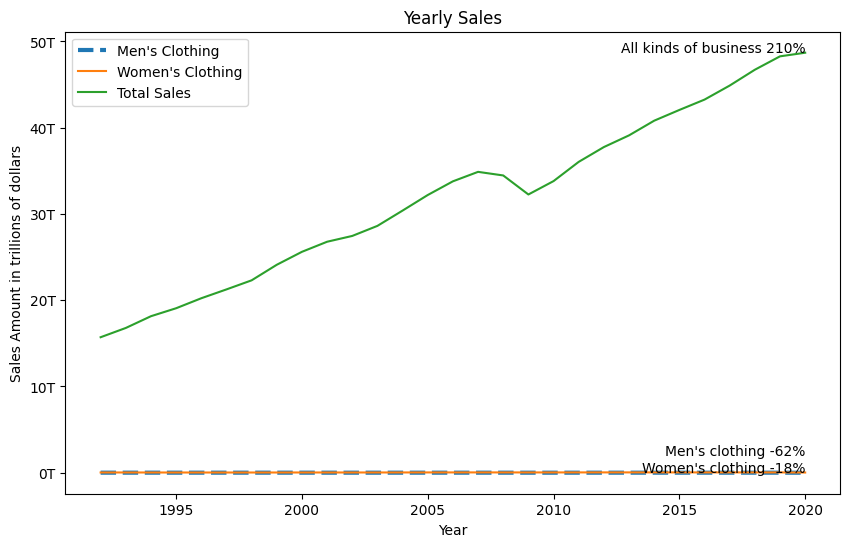

In [11]:
# For each of the two businesses, what is the percentage of contribution to the whole and how does it change over time?

men_clothing_year_sum = men_clothing_df.groupby([men_clothing_df.index.year])[
    "sales_amount"
].sum()

women_clothing_year_sum = women_clothing_df.groupby([women_clothing_df.index.year])[
    "sales_amount"
].sum()

total_year_sum = df.groupby([df.index.year])["sales_amount"].sum()

men_clothing_year_sum = men_clothing_year_sum * 1000000
women_clothing_year_sum = women_clothing_year_sum * 1000000
total_year_sum = total_year_sum * 1000000
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(men_clothing_year_sum.index, men_clothing_year_sum.values, label="Men's Clothing",linestyle='--',linewidth=3)
plt.plot(women_clothing_year_sum.index, women_clothing_year_sum.values, label="Women's Clothing")
plt.plot(total_year_sum.index, total_year_sum.values, label="Total Sales")

# add percetage change text to end of lines
end_men_clothing_year_sum_index = men_clothing_year_sum.index[-1]
end_men_clothing_year_sum_values = men_clothing_year_sum.values[-1]
plt.text(
    end_men_clothing_year_sum_index,
    end_men_clothing_year_sum_values + 2000000000000,
    "Men's clothing " + f"{(
        (men_clothing_year_sum.values[-1] - men_clothing_year_sum.values[0])
        / men_clothing_year_sum.values[0]
    ):.0%}",
    ha="right",
)

end_women_clothing_year_sum_index = women_clothing_year_sum.index[-1]
end_women_clothing_year_sum_values = women_clothing_year_sum.values[-1]
plt.text(
    end_women_clothing_year_sum_index,
    end_women_clothing_year_sum_values,
    "Women's clothing " + f"{(
        (women_clothing_year_sum.values[-1] - women_clothing_year_sum.values[0])
        / women_clothing_year_sum.values[0]
    ):.0%}",
    ha="right",
)

end_total_year_sum_index = total_year_sum.index[-1]
end_total_year_sum_values = total_year_sum.values[-1]
print(end_total_year_sum_values)
plt.text(
    end_total_year_sum_index,
    end_total_year_sum_values,
    "All kinds of business " + f"{(
        (total_year_sum.values[-1] - total_year_sum.values[0])
        / total_year_sum.values[0]
    ):.0%}",
    ha="right",
)

# Formatting
plt.xlabel("Year")
plt.ylabel("Sales Amount in trillions of dollars")
plt.title("Yearly Sales")
plt.legend()
import matplotlib.ticker as ticker

# Your code to create the plot and set the y-axis values

# Define the function to format the y-axis labels
def trillions_formatter(x, pos):
  return f'{x/1e12:.0f}T'

# Set the formatter for the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(trillions_formatter))

# Display the plot
plt.show()

# Explore rolling time windows


C:\Users\andre\AppData\Local\Temp\ipykernel_14156\3813872304.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")["sales_amount"]
C:\Users\andre\AppData\Local\Temp\ipykernel_14156\3813872304.py:21: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  office_supplies_sum_per_year = df[df['kind_of_business'] == 'Office supplies, stationery, and gift stores'].resample('Y')['sales_amount'].sum()
C:\Users\andre\AppData\Local\Temp\ipykernel_14156\3813872304.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pharmacies_sum_per_year = df[df['kind_of_business'] == 'Pharmacies and drug stores'].resample('Y')['sales_amount'].sum()


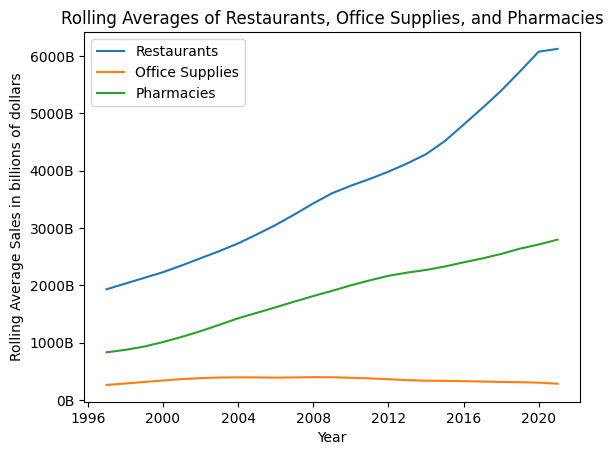

In [33]:
# See the 5 year rolling average of sales for these 3 kinds of businesses

# Group the data by year and calculate the sum of sales_amount
# restaurants_sum_per_year = (
#     df[df["kind_of_business"] == "Restaurants and other eating places"]
#     .groupby("year")["sales_amount"]
#     .sum()
# )

# alternatively, instead of groupby, we can use resample, but note that if one kind of business uses groupby, all have to use groupby, and vice versa. Resample works on time data.

restaurants_sum_per_year = (
    df[df["kind_of_business"] == "Restaurants and other eating places"]
    .resample("Y")["sales_amount"]
    .sum()
)

restaurants_sum_per_year = restaurants_sum_per_year * 1000000

# office_supplies_sum_per_year = df[df['kind_of_business'] == 'Office supplies, stationery, and gift stores'].groupby('year')['sales_amount'].sum()
office_supplies_sum_per_year = df[df['kind_of_business'] == 'Office supplies, stationery, and gift stores'].resample('Y')['sales_amount'].sum()

office_supplies_sum_per_year = office_supplies_sum_per_year * 1000000

# pharmacies_sum_per_year = df[df['kind_of_business'] == 'Pharmacies and drug stores'].groupby('year')['sales_amount'].sum()
pharmacies_sum_per_year = df[df['kind_of_business'] == 'Pharmacies and drug stores'].resample('Y')['sales_amount'].sum()

pharmacies_sum_per_year = pharmacies_sum_per_year * 1000000

# rolling takes a window of rows and calculates an aggregate function on them.
restaurants_rolling_avg = restaurants_sum_per_year.rolling(window=5).mean()
office_supplies_rolling_avg = office_supplies_sum_per_year.rolling(window=5).mean()
pharmacies_rolling_avg = pharmacies_sum_per_year.rolling(window=5).mean()

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the rolling averages as lines
ax.plot(restaurants_rolling_avg.index, restaurants_rolling_avg, label='Restaurants')
ax.plot(office_supplies_rolling_avg.index, office_supplies_rolling_avg, label='Office Supplies')
ax.plot(pharmacies_rolling_avg.index, pharmacies_rolling_avg, label='Pharmacies')

# Set the x-axis label
ax.set_xlabel('Year')

# Set the y-axis label
ax.set_ylabel('Rolling Average Sales in billions of dollars')

# Set the title
ax.set_title('Rolling Averages of Restaurants, Office Supplies, and Pharmacies')

# Add a legend
ax.legend()


# Define the function to format the y-axis labels
def billions_formatter(x, pos):
    return f"{x/1e8:.0f}B"


# Set the formatter for the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))

# Display the chart
plt.show()

In [13]:
# # Close the cursor and connection
cursor.close()
cnx.close()